In this document I will run a sequence of analysis of the examples in MSCOCO dataset, regarding the format of the captions and the elements of the segmentation data.

In doing so I will better understand the composition of the dataset and decide if a certain problem in the recoloration algorithm can be solved by just ignoring the problematic elements, but just if they are a small enough subset of the total dataset.

# Data Loading

In [22]:
import json

In [26]:
train_captions_file='../../src/data/annotations/captions_train2017.json'
val_captions_file='../../src/data/annotations/captions_val2017.json'

with open(train_captions_file, 'r') as f:
    train_captions_data = json.load(f)
with open(val_captions_file, 'r') as f:
    val_captions_data = json.load(f)

In [6]:
def delete_folder(folder_path):
    if os.path.exists(folder_path):
        for root, dirs, files in os.walk(folder_path, topdown=False):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.rmdir(dir_path)
        os.rmdir(folder_path)

delete_folder('/content/coco_train2017')
delete_folder('/content/coco_val2017')


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [1]:
import re
import sys
import time

In [2]:
print(sys.executable)

/opt/homebrew/opt/python@3.9/bin/python3.9


# Counting Color Reference 

I will count how many times a color is referred:
- Counting for each caption
- Counting one time for example (an image has 4/5 captions)

In [25]:
colors = ['red', 'blue', 'green', 'yellow', 'black', 'white', 'pink', 'purple', 'orange', 'brown', 'grey', 'gray','cyan']

In [13]:
def count_color_reference(captions_data):
    images_ids = set(annotation['image_id'] for annotation in captions_data['annotations'])

    sing_ref_capt=0
    mult_ref_capt=0

    n_captions = 0

    sing_ref_img=set()
    mult_ref_img=set()


    start_time = time.time()

    for idx, image_id in enumerate(images_ids):
        captions = [annotation['caption'] for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]
        for caption in captions:
            n_captions+=1
            colors_found = 0
            for color in colors:
                pattern = rf"\b{color}\b"
                matches = re.findall(pattern, caption)
                colors_found += len(matches)
                if colors_found > 1 :
                  mult_ref_img.add(image_id)
                  mult_ref_capt+=1
                  break
            if colors_found == 1:
              sing_ref_img.add(image_id)
              sing_ref_capt+=1

        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{len(images_ids)} images, "
            f"found {sing_ref_capt} captions with a single color reference and {mult_ref_capt} with multiple, respectively in {len(sing_ref_img)} and {len(mult_ref_img)} images  "
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return n_captions, sing_ref_capt, mult_ref_capt, len(images_ids), len(sing_ref_img), len(mult_ref_img), len(sing_ref_img.intersection(mult_ref_img))

Val run

In [14]:
n_capt, sing_ref_capt, mult_ref_capt, n_imgs, sing_ref_img, mult_ref_img, singmult_ref_img = count_color_reference(val_captions_data)

Checked 5000/5000 images, found 3008 captions with a single color reference and 1075 with multiple, respectively in 1942 and 829 images  Elapsed Time: 4.91s, Estimated Remaining Time: 0.00s

Display Val x caption

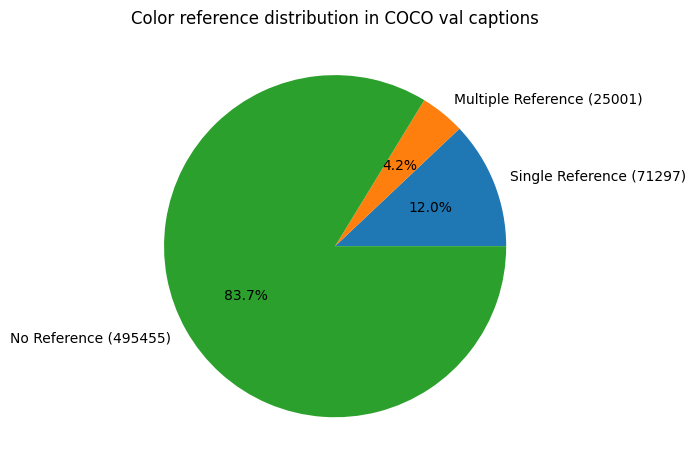

In [29]:
no_color = n_capt - sing_ref_capt - mult_ref_capt
x = [sing_ref_capt, mult_ref_capt, no_color]
labels = [f'Single Reference ({sing_ref_capt})', f'Multiple Reference ({mult_ref_capt})', f'No Reference ({no_color})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Color reference distribution in COCO val captions')
plt.tight_layout()
plt.savefig('color_reference_val_xcap')
plt.show()

Display Val x image

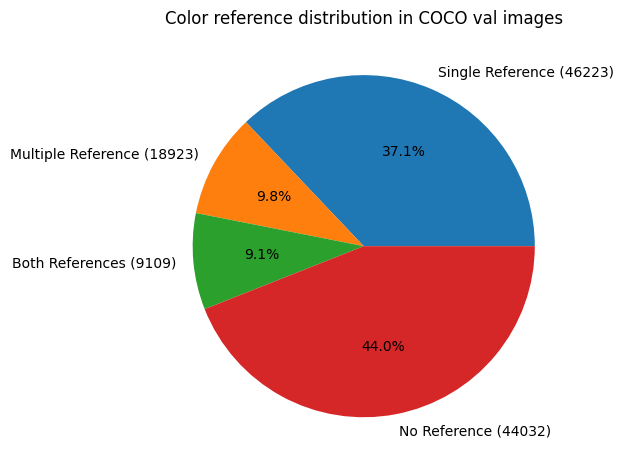

In [30]:
no_color = n_imgs - sing_ref_img - mult_ref_img - singmult_ref_img
x = [sing_ref_img - singmult_ref_img, mult_ref_img - singmult_ref_img, singmult_ref_img,no_color]
labels = [f'Single Reference ({sing_ref_img})', f'Multiple Reference ({mult_ref_img})', f'Both References ({singmult_ref_img})', f'No Reference ({no_color})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Color reference distribution in COCO val images')
plt.tight_layout()
plt.savefig('color_reference_val_ximg')
plt.show()

Train run

In [21]:
n_capt,sing_ref_capt, mult_ref_capt, n_imgs, sing_ref_img, mult_ref_img, singmult_ref_img = count_color_reference(train_captions_data)

Checked 118287/118287 images, found 71297 captions with a single color reference and 25001 with multiple, respectively in 46223 and 18923 images  Elapsed Time: 2217.87s, Estimated Remaining Time: 0.00sss

Dsiplay train x caption

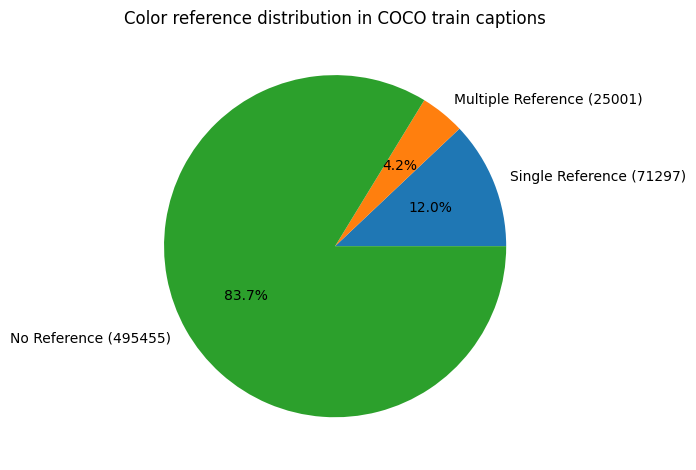

In [31]:
no_color = n_capt - sing_ref_capt - mult_ref_capt
x = [sing_ref_capt, mult_ref_capt, no_color]
labels = [f'Single Reference ({sing_ref_capt})', f'Multiple Reference ({mult_ref_capt})', f'No Reference ({no_color})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Color reference distribution in COCO train captions')
plt.tight_layout()
plt.savefig('color_reference_train_xcap')
plt.show()

Display train x image

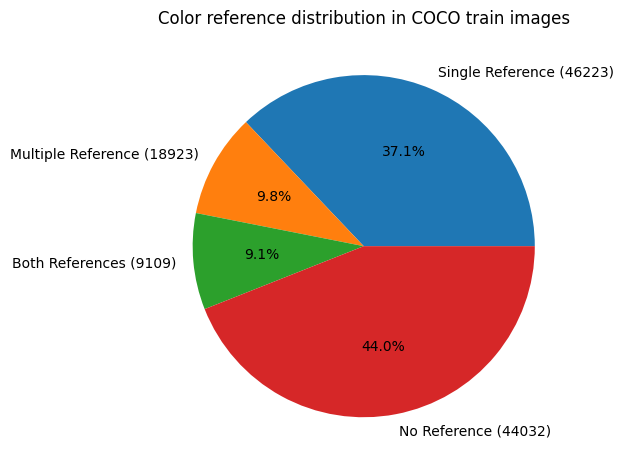

In [32]:
no_color = n_imgs - sing_ref_img - mult_ref_img - singmult_ref_img
x = [sing_ref_img - singmult_ref_img, mult_ref_img - singmult_ref_img, singmult_ref_img,no_color]
labels = [f'Single Reference ({sing_ref_img})', f'Multiple Reference ({mult_ref_img})', f'Both References ({singmult_ref_img})', f'No Reference ({no_color})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Color reference distribution in COCO train images')
plt.tight_layout()
plt.savefig('color_reference_train_ximg')
plt.show()

# Color Reference Format

I will study how the color is referred:
- {color} {noun}                        Example: a grey cat
- {color} and {adjective} {noun}        Example: a blue and bright lake
- {noun} in {color}                     Example: the lady in red

In [50]:
import json

input_file = 'colored_train.json' # I previously filtered the dataset so I use it to run the current algorithm

with open(input_file, 'r') as f:
    colored_train = set(json.load(f))

input_file = 'colored_val.json' # I previously filtered the dataset so I use it to run the current algorithm

with open(input_file, 'r') as f:
    colored_val = set(json.load(f))

In [ ]:
import spacy
!python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

import inflect

p = inflect.engine()

def plural_to_singular(word):
    if p.singular_noun(word):
        return p.singular_noun(word)
    else:
        return word

In [35]:
import time
import sys

def color_reference_format(dataset):

    instances_file = None
    captions_data = None
    images_ids = set()

    if dataset == 'train':
        instances_file = 'coco_ann2017/annotations/instances_train2017.json'
        with open(instances_file, 'r') as f:
            instances_data = json.load(f)
        captions_data = train_captions_data
        image_ids_with_instances = set(annotation['image_id'] for annotation in instances_data['annotations'])
        images_ids = colored_train.intersection(image_ids_with_instances)

    elif dataset == 'val':
        instances_file = 'coco_ann2017/annotations/instances_val2017.json'
        with open(instances_file, 'r') as f:
            instances_data = json.load(f)
        captions_data = val_captions_data
        image_ids_with_instances = set(annotation['image_id'] for annotation in instances_data['annotations'])
        images_ids = colored_val.intersection(image_ids_with_instances)

    categories = {category['id']: category['name'] for category in instances_data['categories']}

    n_col_noun = 0
    n_col_adj = 0
    n_noun_in = 0

    start_time = time.time()
    total_images = len(images_ids)
    colored_not_found = []

    for idx, image_id in enumerate(images_ids):
        category_ids = {annotation['category_id'] for annotation in instances_data['annotations'] if annotation['image_id'] == image_id}
        category_names = [categories[category_id] for category_id in category_ids]
        captions = [annotation['caption'] for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]

        for caption in captions:
            filter_match = False
            colored = False

            doc = nlp(caption)
            for i, token in enumerate(doc):
                if token.text.lower() in colors:
                    colored = True
                    # Pattern 1: {color} {noun}
                    if i < len(doc) - 1:
                        next_token = doc[i + 1]
                        if next_token.pos_ == 'NOUN':
                            n_col_noun += 1
                            filter_match = True
                            break

                    # Pattern 2: {color} and {adjective} {noun}
                    if i < len(doc) - 3:
                        and_token = doc[i + 1]
                        adj_token = doc[i + 2]
                        noun_token = doc[i + 3]
                        if and_token.text.lower() == 'and' and adj_token.pos_ == 'ADJ' and noun_token.pos_ == 'NOUN':
                            n_col_adj += 1
                            filter_match = True
                            break

                    # Pattern 3: {noun} in {color}
                    if i > 1:
                        prev_token = doc[i - 1]
                        prev_prev_token = doc[i - 2]
                        if prev_token.text.lower() == 'in' and prev_prev_token.pos_ == 'NOUN':
                            n_noun_in += 1
                            filter_match = True
                            break

            if not filter_match and colored:
                colored_not_found.append(caption)

        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{total_images} images, "
            f"found {n_col_noun} color noun, {n_col_adj} color adjective and {n_noun_in} noun in. {len(colored_not_found)} Captions with color in another format. Colored "
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return n_col_noun, n_col_adj, n_noun_in, colored_not_found


Run Val

In [28]:
n_col_noun, n_col_adj, n_noun_in, colored_not_found = color_reference_format('val')

Checked 2327/2327 images, found 3057 color noun, 563 color adjective and 25 noun in. 453 Captions with color in another format. Elapsed Time: 64.30s, Estimated Remaining Time: 0.00ss

Display Val results x cap

In [49]:
import random

sample_not_found = random.sample(colored_not_found,15)
print(sample_not_found)


with open('alternative_color_format_val', 'w') as json_file:
    json.dump(list(colored_not_found), json_file)

['Black and white cat, with TV remote, laying on couch.', 'A red double decker bus headed to Victoria is parked on the side of the street.', 'An orange sitting in the middle of a road', 'A brown medium sized dog stares out of a window.', 'Bathroom with a white tiled floor and sink.', 'an orange sitting on top of a wooden table', 'A grey and white cat watches from between parked cars.', 'a green and white street sign some cars and buildings', 'A boy wearing yellow is holding a pizza in a box.', 'The grey and white cat stares up near a laptop.', 'Elderly  gray haired man in a suit scowling into the camera.', 'A white frosted donut with sprinkles and a jump rope with leather roping next to it.', 'a yellow and blue public bus driving down the road by some flowers', 'A man with blue jersey holding a baseball bat.', 'A neglected black and white Pitbull Terrier puppy in a filthy environment with garbage is reflected in an old mirror.']


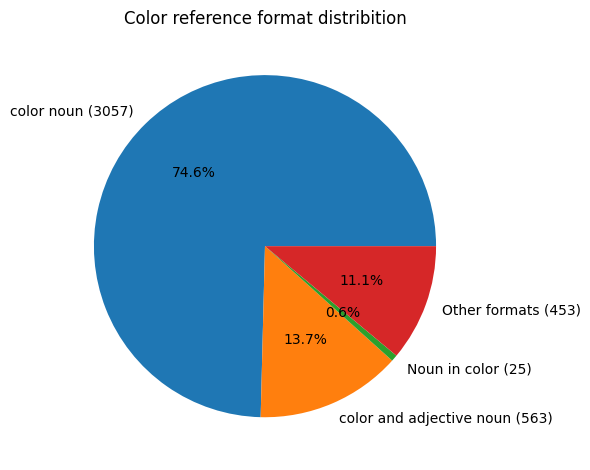

In [44]:
import matplotlib.pyplot as plt

x = [n_col_noun, n_col_adj, n_noun_in, len(colored_not_found)]
labels = [f'color noun ({n_col_noun})', f'color and adjective noun ({n_col_adj})', f'Noun in color ({n_noun_in})', f'Other formats ({len(colored_not_found)})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Color reference format distribition')
plt.tight_layout()
plt.savefig('color_reference_format_val_xcap')
plt.show()

Run Train

In [36]:
n_col_noun, n_col_adj, n_noun_in, colored_not_found = color_reference_format('train')

Checked 55473/55473 images, found 71904 color noun, 13341 color adjective and 930 noun in. 10726 Captions with color in another format. Colored Elapsed Time: 86048.21s, Estimated Remaining Time: 0.00ssss

ValueError: not enough values to unpack (expected 5, got 4)

Display train results xcap

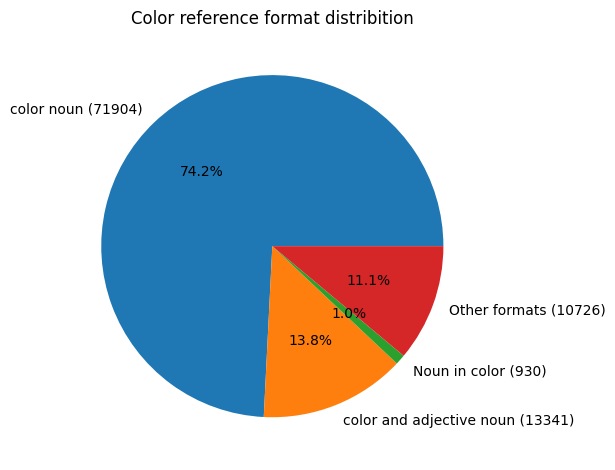

In [45]:
t_value1=71904
t_value2=13341 
t_value3=930
t_value4 = 10726

x = [t_value1,t_value2,t_value3,t_value4]
labels = [f'color noun ({t_value1})', f'color and adjective noun ({t_value2})', f'Noun in color ({t_value3})', f'Other formats ({t_value4})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Color reference format distribition')
plt.tight_layout()
plt.savefig('color_reference_format_train_xcap')
plt.show()

# Multiple Entity Study

In [ ]:
def countCategoryInstances(instances_data, img_id, category_name):
    category_id = None
    for category in instances_data['categories']:
        if category['name'] == category_name:
            category_id = category['id']
            break

    if category_id is None:
        return 0

    count = 0
    for annotation in instances_data['annotations']:
        if annotation['image_id'] == img_id and annotation['category_id'] == category_id:
            count += 1

    return count

In [ ]:
import time
import sys
import re

def entity_study(dataset):

    instances_file = None
    captions_data = None
    images_ids = set()

    if dataset == 'train':
        instances_file = 'coco_ann2017/annotations/instances_train2017.json'
        with open(instances_file, 'r') as f:
            instances_data = json.load(f)
        captions_data = train_captions_data
        image_ids_with_instances = set(annotation['image_id'] for annotation in instances_data['annotations'])
        images_ids = colored_train.intersection(image_ids_with_instances)

    elif dataset == 'val':
        instances_file = 'coco_ann2017/annotations/instances_val2017.json'
        with open(instances_file, 'r') as f:
            instances_data = json.load(f)
        captions_data = val_captions_data
        image_ids_with_instances = set(annotation['image_id'] for annotation in instances_data['annotations'])
        images_ids = colored_val.intersection(image_ids_with_instances)

    categories = {category['id']: category['name'] for category in instances_data['categories']}
    category_id_to_name = {category['id']: category['name'] for category in instances_data['categories']}

    #Here I define what I want to study
    no_entity_x_cap = set()
    no_entity_x_img = 0

    single_entity_x_cap = set()
    multipl_entity_x_cap = set()

    single_entity_x_img_single_color = set()
    single_entity_x_img_multiple_color = set()

    multiple_entity_x_img_single_color = set()
    multiple_entity_x_img_multiple_color = set()

    img_right_format = set()
    caption_right_format = set()

    start_time = time.time()
    total_images = len(images_ids)


    for idx, image_id in enumerate(images_ids):
        category_ids = {annotation['category_id'] for annotation in instances_data['annotations'] if annotation['image_id'] == image_id}
        category_names = [categories[category_id] for category_id in category_ids]
        captions_with_ids = [(annotation['caption'], annotation['id']) for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]

        entity_in_img = []

        for caption, caption_id in captions_with_ids:
            doc = nlp(caption)
            entity_in_cap = []

            for i, token in enumerate(doc):
                for color in colors:
                    pattern = rf"\b{color}\b"
                    matches = re.findall(pattern, caption)
                    if len(matches) > 0:
                        # Pattern 1: {color} {noun}
                        if i < len(doc) - 1:
                            next_token = doc[i + 1]
                            if next_token.pos_ == 'NOUN':

                                img_right_format.add(image_id)
                                caption_right_format.add(caption_id)

                                singular_noun = plural_to_singular(next_token.text)

                                if singular_noun in category_names:
                                    count_instances = countCategoryInstances(instances_data, image_id, singular_noun)
                                    if count_instances == 1:
                                        single_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            single_entity_x_img_single_color.add(image_id)
                                        else:
                                            single_entity_x_img_multiple_color.add(image_id)
                                    elif count_instances>1:
                                        multipl_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            multiple_entity_x_img_single_color.add(image_id)
                                        else:
                                            multiple_entity_x_img_multiple_color.add(image_id)




                        # Pattern 2: {color} and {adjective} {noun}
                        if i < len(doc) - 3:
                            and_token = doc[i + 1]
                            adj_token = doc[i + 2]
                            noun_token = doc[i + 3]
                            if and_token.text.lower() == 'and' and adj_token.pos_ == 'ADJ' and noun_token.pos_ == 'NOUN':

                                img_right_format.add(image_id)
                                caption_right_format.add(caption_id)

                                singular_noun = plural_to_singular(noun_token.text)

                                if singular_noun in category_names:
                                    count_instances = countCategoryInstances(instances_data, image_id, singular_noun)
                                    if count_instances == 1:
                                        single_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            single_entity_x_img_single_color.add(image_id)
                                        else:
                                            single_entity_x_img_multiple_color.add(image_id)
                                    elif count_instances>1:
                                        multipl_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            multiple_entity_x_img_single_color.add(image_id)
                                        else:
                                            multiple_entity_x_img_multiple_color.add(image_id)

                        # Pattern 3: {noun} in {color}
                        if i > 1:
                            prev_token = doc[i - 1]
                            prev_prev_token = doc[i - 2]
                            if prev_token.text.lower() == 'in' and prev_prev_token.pos_ == 'NOUN':

                                img_right_format.add(image_id)
                                caption_right_format.add(caption_id)

                                singular_noun = plural_to_singular(prev_prev_token.text)

                                if singular_noun in category_names:
                                    count_instances = countCategoryInstances(instances_data, image_id, singular_noun)
                                    if count_instances == 1:
                                        single_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            single_entity_x_img_single_color.add(image_id)
                                        else:
                                            single_entity_x_img_multiple_color.add(image_id)
                                    elif count_instances>1:
                                        multipl_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            multiple_entity_x_img_single_color.add(image_id)
                                        else:
                                            multiple_entity_x_img_multiple_color.add(image_id)
            
            if caption_id not in single_entity_x_cap.union(multipl_entity_x_cap) and caption_id in caption_right_format:
                no_entity_x_cap.add((caption,tuple(category_names)))
                               
        if image_id not in single_entity_x_img_single_color.union(single_entity_x_img_multiple_color).union(multiple_entity_x_img_single_color).union(multiple_entity_x_img_multiple_color) and image_id in img_right_format :
            no_entity_x_img+=1


        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{total_images} images, "
            f"found {len(no_entity_x_cap)} captions with no entity, {len(single_entity_x_cap)} with single entity and {len(multipl_entity_x_cap)} with multiple "
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return  [no_entity_x_cap, no_entity_x_img, single_entity_x_cap, multipl_entity_x_cap, single_entity_x_img_single_color, single_entity_x_img_multiple_color, multiple_entity_x_img_single_color, multiple_entity_x_img_multiple_color]


In [ ]:
results = entity_study('val')

Checked 2327/2327 images, found 1500 captions with no entity, 1886 with single entity and 795 with multiple Elapsed Time: 82.48s, Estimated Remaining Time: 0.00ss

Display Entity results x cap

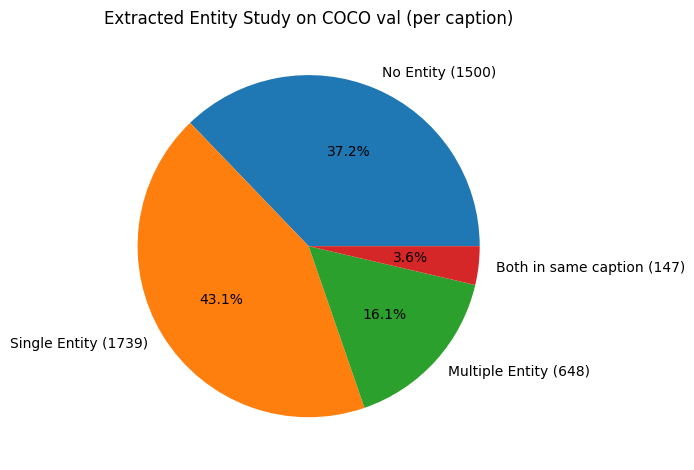

In [ ]:
cap_no_ent = len(results[0])
cap_both = len(results[2].intersection(results[3]))
cap_sing_ent = len(results[2]) - cap_both
cap_mult_ent = len(results[3]) - cap_both

x=[cap_no_ent,cap_sing_ent,cap_mult_ent,cap_both]
labels = [f'No Entity ({cap_no_ent})', f'Single Entity ({cap_sing_ent})', f'Multiple Entity ({cap_mult_ent})', f'Both in same caption ({cap_both})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Extracted Entity Study on COCO val (per caption)')
plt.tight_layout()
plt.savefig('entity_study_val_xcap')
plt.show()

Display Entity results x img

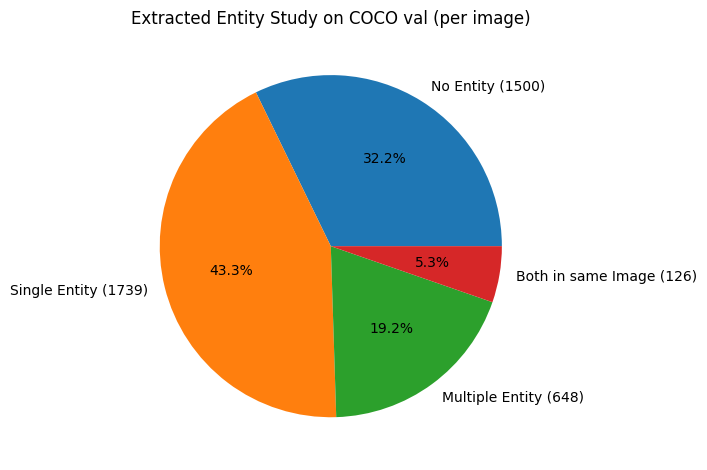

In [ ]:
img_no_ent = results[1]
img_both = len((results[4].union(results[5])).intersection((results[6].union(results[7]))))
img_sing_ent = len(results[4]) + len(results[5]) - img_both
img_mult_ent = len(results[6]) + len(results[7]) - img_both

x=[img_no_ent,img_sing_ent,img_mult_ent,img_both]
labels = [f'No Entity ({cap_no_ent})', f'Single Entity ({cap_sing_ent})', f'Multiple Entity ({cap_mult_ent})', f'Both in same Image ({img_both})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Extracted Entity Study on COCO val (per image)')
plt.tight_layout()
plt.savefig('entity_study_val_ximg')
plt.show()

Study on No found entities

In [ ]:
with open('not_found_entity', 'w') as json_file:
    json.dump(list(results[0]), json_file)

In [ ]:
results_train = entity_study('train') #Checked 21455/117266 images, found 970 images having multiple instances for color reffered category.Elapsed Time: 6741.06s

Checked 56/55473 images, found 34 captions with no entity, 56 with single entity and 17 with multiple Elapsed Time: 79.18s, Estimated Remaining Time: 78353.87s

KeyboardInterrupt: 

In [55]:
def countCategoryInstances(instances_data, img_id, category_name):
    category_id = None
    for category in instances_data['categories']:
        if category['name'] == category_name:
            category_id = category['id']
            break

    if category_id is None:
        return 0

    count = 0
    for annotation in instances_data['annotations']:
        if annotation['image_id'] == img_id and annotation['category_id'] == category_id:
            count += 1

    return count

In [90]:
import time
import sys
import re

def entity_study(dataset):

    instances_file = None
    captions_data = None
    images_ids = set()

    if dataset == 'train':
        instances_file = 'coco_ann2017/annotations/instances_train2017.json'
        with open(instances_file, 'r') as f:
            instances_data = json.load(f)
        captions_data = train_captions_data
        image_ids_with_instances = set(annotation['image_id'] for annotation in instances_data['annotations'])
        images_ids = colored_train.intersection(image_ids_with_instances)

    elif dataset == 'val':
        instances_file = 'coco_ann2017/annotations/instances_val2017.json'
        with open(instances_file, 'r') as f:
            instances_data = json.load(f)
        captions_data = val_captions_data
        image_ids_with_instances = set(annotation['image_id'] for annotation in instances_data['annotations'])
        images_ids = colored_val.intersection(image_ids_with_instances)

    categories = {category['id']: category['name'] for category in instances_data['categories']}
    category_id_to_name = {category['id']: category['name'] for category in instances_data['categories']}

    #Here I define what I want to study
    no_entity_x_cap = set()
    no_entity_x_img = 0

    single_entity_x_cap = set()
    multipl_entity_x_cap = set()

    single_entity_x_img_single_color = set()
    single_entity_x_img_multiple_color = set()

    multiple_entity_x_img_single_color = set()
    multiple_entity_x_img_multiple_color = set()

    img_right_format = set()
    caption_right_format = set()

    start_time = time.time()
    total_images = len(images_ids)


    for idx, image_id in enumerate(images_ids):
        category_ids = {annotation['category_id'] for annotation in instances_data['annotations'] if annotation['image_id'] == image_id}
        category_names = [categories[category_id] for category_id in category_ids]
        captions_with_ids = [(annotation['caption'], annotation['id']) for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]

        entity_in_img = []

        for caption, caption_id in captions_with_ids:
            doc = nlp(caption)
            entity_in_cap = []

            for i, token in enumerate(doc):
                for color in colors:
                    pattern = rf"\b{color}\b"
                    matches = re.findall(pattern, caption)
                    if len(matches) > 0:
                        # Pattern 1: {color} {noun}
                        if i < len(doc) - 1:
                            next_token = doc[i + 1]
                            if next_token.pos_ == 'NOUN':

                                img_right_format.add(image_id)
                                caption_right_format.add(caption_id)

                                singular_noun = plural_to_singular(next_token.text)

                                if singular_noun in category_names:
                                    count_instances = countCategoryInstances(instances_data, image_id, singular_noun)
                                    if count_instances == 1:
                                        single_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            single_entity_x_img_single_color.add(image_id)
                                        else:
                                            single_entity_x_img_multiple_color.add(image_id)
                                    elif count_instances>1:
                                        multipl_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            multiple_entity_x_img_single_color.add(image_id)
                                        else:
                                            multiple_entity_x_img_multiple_color.add(image_id)




                        # Pattern 2: {color} and {adjective} {noun}
                        if i < len(doc) - 3:
                            and_token = doc[i + 1]
                            adj_token = doc[i + 2]
                            noun_token = doc[i + 3]
                            if and_token.text.lower() == 'and' and adj_token.pos_ == 'ADJ' and noun_token.pos_ == 'NOUN':

                                img_right_format.add(image_id)
                                caption_right_format.add(caption_id)

                                singular_noun = plural_to_singular(noun_token.text)

                                if singular_noun in category_names:
                                    count_instances = countCategoryInstances(instances_data, image_id, singular_noun)
                                    if count_instances == 1:
                                        single_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            single_entity_x_img_single_color.add(image_id)
                                        else:
                                            single_entity_x_img_multiple_color.add(image_id)
                                    elif count_instances>1:
                                        multipl_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            multiple_entity_x_img_single_color.add(image_id)
                                        else:
                                            multiple_entity_x_img_multiple_color.add(image_id)

                        # Pattern 3: {noun} in {color}
                        if i > 1:
                            prev_token = doc[i - 1]
                            prev_prev_token = doc[i - 2]
                            if prev_token.text.lower() == 'in' and prev_prev_token.pos_ == 'NOUN':

                                img_right_format.add(image_id)
                                caption_right_format.add(caption_id)

                                singular_noun = plural_to_singular(prev_prev_token.text)

                                if singular_noun in category_names:
                                    count_instances = countCategoryInstances(instances_data, image_id, singular_noun)
                                    if count_instances == 1:
                                        single_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            single_entity_x_img_single_color.add(image_id)
                                        else:
                                            single_entity_x_img_multiple_color.add(image_id)
                                    elif count_instances>1:
                                        multipl_entity_x_cap.add(caption_id)
                                        if len(matches) == 1:
                                            multiple_entity_x_img_single_color.add(image_id)
                                        else:
                                            multiple_entity_x_img_multiple_color.add(image_id)
            
            if caption_id not in single_entity_x_cap.union(multipl_entity_x_cap) and caption_id in caption_right_format:
                no_entity_x_cap.add((caption,tuple(category_names)))
                               
        if image_id not in single_entity_x_img_single_color.union(single_entity_x_img_multiple_color).union(multiple_entity_x_img_single_color).union(multiple_entity_x_img_multiple_color) and image_id in img_right_format :
            no_entity_x_img+=1


        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{total_images} images, "
            f"found {len(no_entity_x_cap)} captions with no entity, {len(single_entity_x_cap)} with single entity and {len(multipl_entity_x_cap)} with multiple "
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return  [no_entity_x_cap, no_entity_x_img, single_entity_x_cap, multipl_entity_x_cap, single_entity_x_img_single_color, single_entity_x_img_multiple_color, multiple_entity_x_img_single_color, multiple_entity_x_img_multiple_color]


In [91]:
results = entity_study('val')

Checked 2327/2327 images, found 1500 captions with no entity, 1886 with single entity and 795 with multiple Elapsed Time: 82.48s, Estimated Remaining Time: 0.00ss

Display Entity results x cap

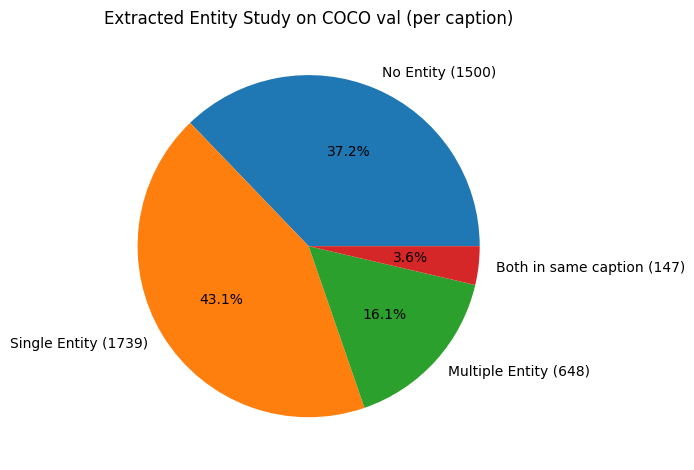

In [92]:
cap_no_ent = len(results[0])
cap_both = len(results[2].intersection(results[3]))
cap_sing_ent = len(results[2]) - cap_both
cap_mult_ent = len(results[3]) - cap_both

x=[cap_no_ent,cap_sing_ent,cap_mult_ent,cap_both]
labels = [f'No Entity ({cap_no_ent})', f'Single Entity ({cap_sing_ent})', f'Multiple Entity ({cap_mult_ent})', f'Both in same caption ({cap_both})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Extracted Entity Study on COCO val (per caption)')
plt.tight_layout()
plt.savefig('entity_study_val_xcap')
plt.show()

Display Entity results x img

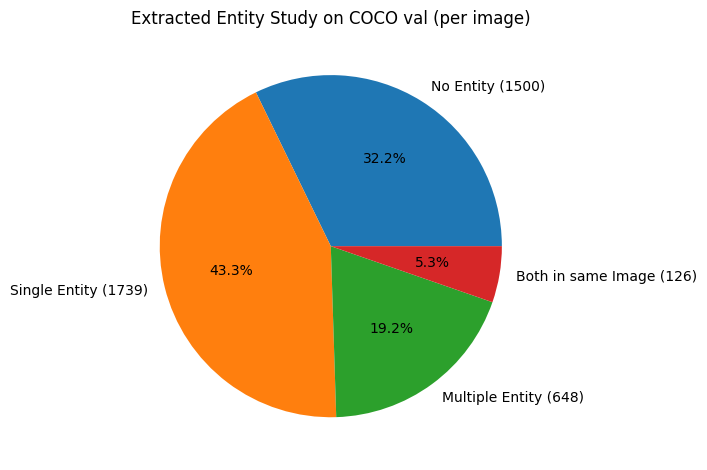

In [93]:
img_no_ent = results[1]
img_both = len((results[4].union(results[5])).intersection((results[6].union(results[7]))))
img_sing_ent = len(results[4]) + len(results[5]) - img_both
img_mult_ent = len(results[6]) + len(results[7]) - img_both

x=[img_no_ent,img_sing_ent,img_mult_ent,img_both]
labels = [f'No Entity ({cap_no_ent})', f'Single Entity ({cap_sing_ent})', f'Multiple Entity ({cap_mult_ent})', f'Both in same Image ({img_both})']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, autopct='%1.1f%%')
ax.set_title('Extracted Entity Study on COCO val (per image)')
plt.tight_layout()
plt.savefig('entity_study_val_ximg')
plt.show()

Study on No found entities

In [95]:
with open('not_found_entity', 'w') as json_file:
    json.dump(list(results[0]), json_file)

In [96]:
results_train = entity_study('train') #Checked 21455/117266 images, found 970 images having multiple instances for color reffered category.Elapsed Time: 6741.06s

Checked 56/55473 images, found 34 captions with no entity, 56 with single entity and 17 with multiple Elapsed Time: 79.18s, Estimated Remaining Time: 78353.87s

KeyboardInterrupt: 

# Problematic Colors study

In [6]:
import sys
import re
import time

animal_reference = {
    'bear': 0,
    'dog': 0,
    'cat': 0,
    'horse': 0,
    'sheep': 0,
    'cow': 0,
    'elephant': 0,
}

def count_dark_color_reference(captions_data):
    images_ids = set(annotation['image_id'] for annotation in captions_data['annotations'])

    black_ref=0
    brown_ref=0

    black_cap = 0
    brown_cap = 0

    black_imgs = set()
    brown_imgs = set()

    n_captions = 0

    start_time = time.time()

    colors = ['brown','black']

    for idx, image_id in enumerate(images_ids):
        captions = [annotation['caption'] for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]
        for caption in captions:
            n_captions+=1
            for color in colors:
                color_found = 0
                pattern = rf"\b{color}\b"
                matches = re.findall(pattern, caption)
                color_found += len(matches)
                if color_found >= 1 :
                    if color == 'black': 
                        black_ref+=color_found
                        black_cap+=1
                        black_imgs.add(image_id)
                    elif color == 'brown':
                        brown_ref += color_found
                        brown_cap+=1
                        brown_imgs.add(image_id)

        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{len(images_ids)} images, "
            f"found {black_ref} black references and {brown_ref} brown reference , {black_cap} captions with at least one black reference, {brown_cap} captions with at least one brown reference, {len(black_imgs)} images with a black reference, {len(brown_imgs)} with a brown reference, {n_captions} captions checked"
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return n_captions, black_ref, brown_ref, black_cap, brown_cap, black_imgs, brown_imgs

In [7]:
dark_imgs_ids= count_dark_color_reference(train_captions_data)

Checked 118287/118287 images, found 18130 black references and 8111 brown reference , 17727 captions with at least one black reference, 7982 captions with at least one brown reference, 12261 images with a black reference, 6130 with a brown reference, 591753 captions checkedElapsed Time: 3021.71s, Estimated Remaining Time: 0.00sss

(591753,
 18130,
 8111,
 17727,
 7982,
 {98304,
  196608,
  524291,
  491525,
  524297,
  458762,
  229387,
  229388,
  196623,
  131089,
  65554,
  426007,
  294937,
  262171,
  131108,
  360485,
  491556,
  163879,
  262184,
  229415,
  294954,
  229419,
  327726,
  262201,
  262204,
  557118,
  360510,
  64,
  294978,
  458821,
  458832,
  458836,
  327768,
  229472,
  327777,
  131172,
  295016,
  295017,
  426094,
  98416,
  131190,
  32888,
  360570,
  360573,
  163965,
  458879,
  557187,
  557188,
  327813,
  426118,
  196742,
  295051,
  98444,
  32909,
  262286,
  491664,
  393362,
  491666,
  32918,
  327834,
  393372,
  262308,
  426151,
  65705,
  393386,
  295092,
  32949,
  524470,
  229559,
  295097,
  491707,
  98493,
  262334,
  32967,
  164040,
  164041,
  295114,
  262347,
  393418,
  458960,
  327896,
  393432,
  458970,
  32990,
  491743,
  262371,
  557283,
  196836,
  229603,
  557291,
  295150,
  33008,
  131312,
  65781,
  98549,
  262394,
  164091,
  229631,


In [8]:
import sys
import re
import time

color_refs = {
    'black': 0,
    'brown': 0,
    'red': 0,
    'blue': 0,
    'green': 0,
    'yellow': 0,
    'white': 0,
    'pink': 0,
    'purple': 0,
    'orange': 0,
    'grey': 0,
    'gray': 0,
    'cyan': 0,
    'violet': 0,
    'magenta': 0,
    'turquoise': 0,
    'gold': 0,
    'silver': 0,
    'azure': 0,
    'maroon': 0,
    'beige': 0,
}



def count_colors(captions_data):
    images_ids = set(annotation['image_id'] for annotation in captions_data['annotations'])

    start_time = time.time()

    for idx, image_id in enumerate(images_ids):
        captions = [annotation['caption'] for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]
        for caption in captions:
            for color in color_refs.keys():
                color_found = 0
                pattern = rf"\b{color}\b"
                matches = re.findall(pattern, caption)
                color_found += len(matches)
                if color_found >= 1 :
                    color_refs[color]+=color_found

        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{len(images_ids)} images, "
            f"{color_refs}"
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return 

In [9]:
count_colors(train_captions_data)

Checked 118287/118287 images, {'black': 18130, 'brown': 8111, 'red': 16808, 'blue': 13457, 'green': 12314, 'yellow': 8130, 'white': 35627, 'pink': 3220, 'purple': 1590, 'orange': 4803, 'grey': 1540, 'gray': 1909, 'cyan': 0, 'violet': 9, 'magenta': 5, 'turquoise': 65, 'gold': 505, 'silver': 1655, 'azure': 5, 'maroon': 115, 'beige': 385}Elapsed Time: 2688.52s, Estimated Remaining Time: 0.00sss

  Using cached matplotlib-3.9.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pillow-10.4.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.1-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.2.1-cp39-cp39-macosx_11_0_arm64.whl (244 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp39-cp39-macosx_11_0_arm64.whl (2.2 MB)
Using cached importlib_resources-6.4.0-py3-none-any.whl (38 kB)
Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.wh

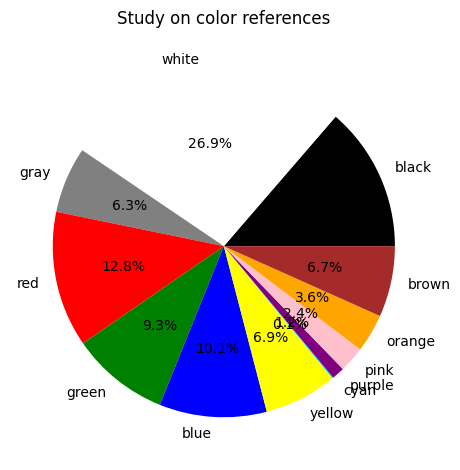

In [12]:
%pip install matplotlib
import matplotlib.pyplot as plt

color_refs['gray'] = color_refs['gray'] + color_refs['grey'] + color_refs['silver'] 
color_refs['cyan'] = color_refs['cyan'] + color_refs['azure'] + color_refs['turquoise']
color_refs['yellow'] = color_refs['yellow'] + color_refs['gold']
color_refs['purple'] = color_refs['purple'] + color_refs['violet']
color_refs['red'] = color_refs['red'] + color_refs['maroon']
color_refs['pink'] = color_refs['pink'] + color_refs['magenta']
color_refs['brown'] = color_refs['brown'] + color_refs['beige']

labels = ['black','white','gray', 'red', 'green', 'blue', 'yellow', 'cyan', 'purple', 'pink', 'orange', 'brown']
x=[]

for color in labels:
    x.append(color_refs[color])

fig, ax = plt.subplots()
ax.pie(x, labels=labels, colors=labels, autopct='%1.1f%%')
ax.set_title('Study on color references')
plt.tight_layout()
plt.savefig('colors')
plt.show()

In [13]:
import json

file_path = 'color_refs.json'

with open(file_path, 'w') as json_file:
    json.dump(color_refs, json_file)

In [18]:
import sys
import re
import time


def count_dark_anymals(captions_data):
    images_ids = set(annotation['image_id'] for annotation in captions_data['annotations'])

    start_time = time.time()

    dark_animals = 0
    checked_animals = 0
    checked_captions = 0

    animals = ['cat','dog','giraffe','horse','bear','seagull','bird','rabbit','lion','tiger','leopard','zebra','elephant','turtle','sheep','cow']
    
    dark_colors = ['black','brown']
    light_colors = ['white','gray','grey','blue','cyan','green','orange','yellow','red','purple','pink']

    for idx, image_id in enumerate(images_ids):
        captions = [annotation['caption'] for annotation in captions_data['annotations'] if annotation['image_id'] == image_id]
        for caption in captions:
                checked_captions+=1
                words = caption.split()

                for i, word in enumerate(words):
                    clean_word = word.strip('.,!?').lower()

                    if clean_word in animals and i > 0:
                        if words[i - 1] in dark_colors:
                            checked_animals+=1
                            dark_animals += 1
                        elif words[i-1] in light_colors:
                            checked_animals+=1

                            


        elapsed_time = time.time() - start_time
        progress = (idx + 1) / len(images_ids)
        estimated_total_time = elapsed_time / progress
        remaining_time = estimated_total_time - elapsed_time

        progress_message = (
            f"Checked {idx + 1}/{len(images_ids)} images, "
            f"Found {dark_animals} animals with a dark color attribute, checked {checked_animals} animals, checked {checked_captions} captions.   "
            f"Elapsed Time: {elapsed_time:.2f}s, Estimated Remaining Time: {remaining_time:.2f}s"
        )
        sys.stdout.write('\r' + progress_message)
        sys.stdout.flush()

    return dark_animals,checked_animals,checked_captions
    

In [19]:
count_dark_anymals(train_captions_data)

Checked 118287/118287 images, Found 6299 animals with a dark color attribute, checked 12269 animals, checked 591753 captions.   Elapsed Time: 2578.28s, Estimated Remaining Time: 0.00sss

(6299, 12269, 591753)